In [1]:
from __future__ import print_function
from six.moves import range

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances,cosine_distances
import time
import sys
import warnings
import os
import pickle
import pandas as pd
import PIL
from tqdm import tqdm_notebook
from keras.applications.inception_v3 import preprocess_input
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from miscc.config import cfg, cfg_from_file
from PIL import Image
import datetime
import dateutil.tz
from datasets import TextDataset
from miscc.utils import mkdir_p
from miscc.utils import build_super_images, build_super_images2
from miscc.utils import weights_init, load_params, copy_G_params
from model import G_DCGAN, G_NET
from datasets import prepare_data
from model import TEXT_TRANSFORMER_ENCODERv2, CNN_ENCODER
# from InceptionScore import calculate_inception_score
from miscc.losses import words_loss
from miscc.losses import discriminator_loss, generator_loss, KL_loss
import torchvision.transforms as transforms
from scipy.linalg import sqrtm

Using TensorFlow backend.
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mshaikh2/anaconda3/envs/pytorch-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

In [14]:
root = '../data/rep_eval/'
clabel_texts = sorted(os.listdir('../data/rep_eval/'))

In [5]:
# def cosine_similarity(x1, x2, dim=1, eps=1e-8):
#     """Returns cosine similarity between x1 and x2, computed along dim.
#     """
#     w12 = np.sum(x1 * x2, dim)
#     w1 = np.linalg.norm(x1, 2, dim)
#     w2 = np.linalg.norm(x2, 2, dim)
#     return (w12 / np.clip(w1 * w2,a_min=eps,a_max=1e8)).squeeze()

In [6]:
class parse_args():
    cfg_file='../code/cfg/coco_attn2.yml'
    gpu_id=0
    data_dir='../data/coco/'
    manualSeed=1
args = parse_args()

In [7]:
def w2i(w=''):
    return [i for i, val in enumerate(np.array(clabel_texts)==w) if val]
def id2imgidx(i=0):
    return [i for i, val in enumerate(y_test==i) if val]
def fid(act1,act2):
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [8]:
args = parse_args()
if args.cfg_file is not None:
    cfg_from_file(args.cfg_file)

if args.gpu_id == -1:
    cfg.CUDA = False
else:
    cfg.GPU_ID = args.gpu_id

if args.data_dir != '':
    cfg.DATA_DIR = args.data_dir
    

print('Using config:')
display(cfg)

split_dir, bshuffle = 'train', True
if not cfg.TRAIN.FLAG:
    # bshuffle = False
    split_dir = 'test'

Using config:


{'DATASET_NAME': 'coco',
 'CONFIG_NAME': 'glu-gan2',
 'DATA_DIR': '../data/coco/',
 'GPU_ID': 0,
 'CUDA': True,
 'WORKERS': 4,
 'RNN_TYPE': 'LSTM',
 'B_VALIDATION': False,
 'TREE': {'BRANCH_NUM': 3, 'BASE_SIZE': 64},
 'TRAIN': {'BATCH_SIZE': 14,
  'MAX_EPOCH': 150,
  'SNAPSHOT_INTERVAL': 2,
  'DISCRIMINATOR_LR': 0.0002,
  'GENERATOR_LR': 0.0002,
  'ENCODER_LR': 0.0002,
  'RNN_GRAD_CLIP': 0.25,
  'FLAG': True,
  'NET_E': '../DAMSMencoders/coco/text_encoder240.pth',
  'NET_G': '../output/coco_glu-gan2_2020_10_25_15_48_15/Model/netG_epoch_130.pth',
  'B_NET_D': True,
  'SMOOTH': {'GAMMA1': 4.0, 'GAMMA3': 10.0, 'GAMMA2': 5.0, 'LAMBDA': 50.0}},
 'GAN': {'DF_DIM': 96,
  'GF_DIM': 48,
  'Z_DIM': 100,
  'CONDITION_DIM': 100,
  'R_NUM': 3,
  'B_ATTENTION': True,
  'B_DCGAN': False},
 'TEXT': {'CAPTIONS_PER_IMAGE': 5, 'EMBEDDING_DIM': 256, 'WORDS_NUM': 15}}

In [9]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
imsize*76/64

304.0

In [10]:
imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM - 1))
image_transform = transforms.Compose([
    transforms.Scale(int(imsize * 76 / 64)),
    transforms.RandomCrop(imsize),
    transforms.RandomHorizontalFlip()])
dataset = TextDataset(cfg.DATA_DIR, split_dir,
                      base_size=cfg.TREE.BASE_SIZE,
                      transform=image_transform)
assert dataset

Load filenames from: ../data/coco//train/filenames.pickle (82783)
Load filenames from: ../data/coco//test/filenames.pickle (40470)
Load from:  ../data/coco/captions.pickle
../data/coco/train


In [11]:
if cfg.TRAIN.NET_G == '':
    print('Error: the path for generator models is not found!')
else:
    
    # Build and load the generator
    if cfg.GAN.B_DCGAN:
        netG = G_DCGAN()
    else:
        netG = G_NET()
    netG.apply(weights_init)
    netG.cuda()
    netG.eval()
    #
    text_encoder = TEXT_TRANSFORMER_ENCODERv2(emb=cfg.TEXT.EMBEDDING_DIM
                                    ,heads=8
                                    ,depth=1
                                    ,seq_length=cfg.TEXT.WORDS_NUM
                                    ,num_tokens=dataset.n_words)
    state_dict = \
        torch.load(cfg.TRAIN.NET_E, map_location=lambda storage, loc: storage)
    text_encoder.load_state_dict(state_dict)
    print('Load text encoder from:', cfg.TRAIN.NET_E)
    text_encoder = text_encoder.cuda()
    text_encoder.eval()

    image_encoder = CNN_ENCODER(cfg.TEXT.EMBEDDING_DIM)
    img_encoder_path = cfg.TRAIN.NET_E.replace('text_encoder', 'image_encoder')
    state_dict = \
        torch.load(img_encoder_path, map_location=lambda storage, loc: storage)
    image_encoder.load_state_dict(state_dict)
    for p in image_encoder.parameters():
        p.requires_grad = False
    print('Load image encoder from:', img_encoder_path)
    image_encoder.eval()


Load text encoder from: ../DAMSMencoders/coco/text_encoder240.pth
Load pretrained model from  https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth
Load image encoder from: ../DAMSMencoders/coco/image_encoder240.pth


In [115]:
clabel_texts

['airplane',
 'apple',
 'backpack',
 'banana',
 'baseball bat',
 'baseball glove',
 'bear',
 'bed',
 'bench',
 'bicycle',
 'bird',
 'boat',
 'book',
 'bottle',
 'bowl',
 'broccoli',
 'bus',
 'cake',
 'car',
 'carrot',
 'cat',
 'cell phone',
 'chair',
 'clock',
 'couch',
 'cow',
 'cup',
 'dining table',
 'dog',
 'donut',
 'elephant',
 'fire hydrant',
 'fork',
 'frisbee',
 'giraffe',
 'hair drier',
 'handbag',
 'horse',
 'hot dog',
 'keyboard',
 'kite',
 'knife',
 'laptop',
 'microwave',
 'motorcycle',
 'mouse',
 'orange',
 'oven',
 'parking meter',
 'person',
 'pizza',
 'potted plant',
 'refrigerator',
 'remote',
 'sandwich',
 'scissors',
 'sheep',
 'sink',
 'skateboard',
 'skis',
 'snowboard',
 'spoon',
 'sports ball',
 'stop sign',
 'suitcase',
 'surfboard',
 'teddy bear',
 'television',
 'tennis racket',
 'tie',
 'toaster',
 'toilet',
 'toothbrush',
 'traffic light',
 'train',
 'truck',
 'umbrella',
 'vase',
 'wine glass',
 'zebra']

In [116]:
idx = 2
clabel_texts[idx]


'backpack'

In [138]:
img_folder  = os.path.join(root,'stop sign')
img_list = os.listdir(img_folder)

In [139]:
# selected_id = w2i('aquarium_fish')[0]
# ids = id2imgidx(selected_id)

In [140]:
imgs = []
for im in img_list:
    imgs.append(np.asarray(Image.open(os.path.join(img_folder,im)).convert('RGB').resize((299,299),PIL.Image.ANTIALIAS),dtype=np.int32))
imgs = np.array(imgs)

In [141]:
imgs.min(),imgs.max()

(0, 255)

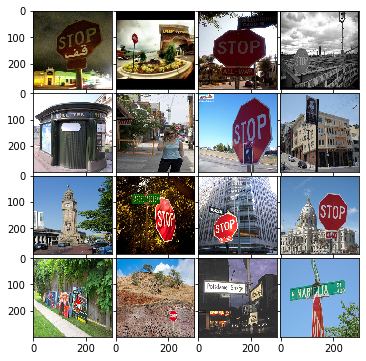

backpack


In [142]:


im1 = np.arange(100).reshape((10, 10))
im2 = im1.T
im3 = np.flipud(im1)
im4 = np.fliplr(im2)

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
         )

for ax, im in zip(grid,imgs[:16]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()
print(clabel_texts[idx])

In [47]:
imgs = preprocess_input(x_test[ids])

In [48]:
imgs.min(),imgs.max()

(-1.0, 1.0)

In [49]:
print(imgs.shape)
i = np.rollaxis(imgs,axis=3,start=1)
i = np.asarray(i,dtype=np.float32)
print(i.shape)

(100, 32, 32, 3)
(100, 3, 32, 32)


In [50]:
img_inp = torch.tensor(i)

In [51]:
r_emb, i_emb = image_encoder(img_inp)

In [52]:
r_emb.shape,i_emb.shape

(torch.Size([100, 256, 17, 17]), torch.Size([100, 256]))

In [53]:
i_emb = np.asarray(i_emb.detach().cpu())


In [83]:
selected_id = w2i('bus')[0]
print(selected_id)
print(clabel_texts[selected_id])
t_inp = [dataset.wordtoix[x] for x in [clabel_texts[selected_id]]]
text_inp = torch.tensor(np.array([t_inp])).cuda()
print(text_inp)

13
bus
tensor([[63]], device='cuda:0')


In [84]:
w_emb,s_emb = text_encoder(text_inp)

In [85]:
w_emb.shape, s_emb.shape

(torch.Size([1, 256, 1]), torch.Size([1, 256]))

In [86]:
s_emb = np.asarray(s_emb.detach().cpu())


In [87]:
s_emb.shape,i_emb.shape

((1, 256), (100, 256))

In [88]:
# [x for x in zip(emb,w_emb[0])]

In [89]:
sims = []
for emb in i_emb:
    sims.append(cosine_similarity([emb],s_emb))
# sims

In [90]:
fid(s_emb,np.array(i_emb))

658.765511474636

In [91]:
df = pd.DataFrame()
df['sims'] = [float(x) for x in sims]

In [130]:
# list(sims)
df.describe()

sims
count  100.000000
mean     0.240041
std      0.071597
min      0.043602
25%      0.189629
50%      0.235504
75%      0.291160
max      0.389651

In [100]:
df.describe().T['mean'].values[0]

-0.03780492545105517

In [384]:
clabel_texts[2]='baby'

In [80]:
keys = list(dataset.wordtoix.keys())
result = {}
for word in tqdm_notebook(clabel_texts):
    if ' ' in word:
        word_ = word.split(' ')[1]
    else:
        word_ = word
    if word_ in keys:
        result[word+'_img']={}        
        img_folder  = os.path.join(root,word)
        img_list = os.listdir(img_folder)
        imgs = []
        for im in img_list:
            try:
                imgs.append(np.asarray(Image.open(os.path.join(img_folder,im)).convert('RGB').resize((299,299),PIL.Image.ANTIALIAS),dtype=np.int32))
            except Exception as ex:
                pass
        imgs = np.array(imgs)
        imgs = preprocess_input(imgs)
        i = np.rollaxis(imgs,axis=3,start=1)
        i = np.asarray(i,dtype=np.float32)
        img_inp = torch.tensor(i)
        r_emb, i_emb = image_encoder(img_inp)
        i_emb = np.asarray(i_emb.detach().cpu())  

        for w in tqdm_notebook(clabel_texts,leave=False):
            if ' ' in w:
                w_ = w.split(' ')
            else:
                w_ = [w]
            if w_[0] in keys:
                result[word+'_img'][w] = {}
                t_inp = [dataset.wordtoix[x] for x in w_]
                text_inp = torch.tensor(np.array([t_inp])).cuda()
                w_emb,s_emb = text_encoder(text_inp)
                s_emb = np.asarray(s_emb.detach().cpu())
                sims = []
                for emb in i_emb:
                    sims.append(cosine_similarity([emb],s_emb))
                df = pd.DataFrame()
                df['sims'] = [float(x) for x in sims]
                result[word+'_img'][w]['c_sim_mean'] = np.around(df.describe().T['mean'].values[0],4)
                result[word+'_img'][w]['c_sim_std'] = np.around(df.describe().T['std'].values[0],4)
                result[word+'_img'][w]['fid'] = np.around(fid(s_emb,np.array(i_emb)),4)

In [473]:
def highlight_max(data, color='lightgreen'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns['c_sim_mean'])

In [82]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 1000
dict_of_df = {k: pd.DataFrame(v).T for k,v in result.items()}
df_result = pd.concat(dict_of_df, axis=1)


In [83]:
df_result

airplane_img                      apple_img            \
                 c_sim_mean c_sim_std       fid c_sim_mean c_sim_std   
airplane             0.6396    0.1094  307.1853    -0.0095    0.0653   
apple               -0.0005    0.0738  553.1912     0.5372    0.1543   
backpack            -0.1565    0.0688  619.1525    -0.0650    0.0622   
banana               0.0825    0.0596  506.9462     0.2379    0.1008   
baseball bat        -0.0403    0.0588  559.9859     0.0494    0.0870   
baseball glove       0.0686    0.0635  533.3044     0.0459    0.0806   
bear                -0.0176    0.0614  552.2187     0.0419    0.0712   
bed                  0.0468    0.0457  545.7260     0.0441    0.0840   
bench                0.0381    0.0480  536.1779    -0.0671    0.0761   
bicycle             -0.1142    0.0466  600.5406    -0.0334    0.0580   
bird                -0.0141    0.1135  574.8507     0.1637    0.1049   
boat                 0.0356    0.0901  542.9811    -0.0102    0.0613   
book                 0.0589    0.0510  529.7196    -0.0364    0.0872   
bottle              -0.0219    0.0500  567.3765    -0.0171    0.0721   
bowl                 0.0604    0.0665  536.7747     0.1920    0.1100   
broccoli            -0.0234    0.0368  578.6560     0.0105    0.1027   
bus                  0.1311    0.0831  508.7266    -0.0170    0.0609   
cake                -0.0115    0.0549  547.6870    -0.0274    0.1115   
car                 -0.0398    0.0762  579.6774    -0.0216    0.0648   
carrot               0.0771    0.0648  505.0149     0.1766    0.1092   
cat                 -0.0027    0.0530  571.6072    -0.0218    0.0714   
cell phone          -0.0197    0.0565  593.4520     0.0664    0.0602   
chair                0.0190    0.0593  545.6487    -0.0836    0.0667   
clock               -0.0623    0.0925  588.8762     0.0284    0.0775   
couch                0.0433    0.0474  536.6913     0.0299    0.0700   
cow                  0.1046    0.0543  504.1594    -0.0209    0.0797   
cup                  0.0392    0.0501  535.6361    -0.0058    0.1226   
dining table        -0.0299    0.0632  576.6620    -0.0959    0.0678   
dog                 -0.0591    0.0446  591.4740    -0.0312    0.0610   
donut                0.0265    0.0492  531.2643     0.2524    0.1347   
elephant            -0.0080    0.0427  567.9235     0.0666    0.0666   
fire hydrant        -0.0878    0.0619  565.7581    -0.0036    0.0830   
fork                 0.0148    0.0596  544.9364    -0.0089    0.1081   
frisbee              0.0435    0.0677  524.0618     0.0219    0.0829   
giraffe              0.0005    0.0516  540.1925    -0.0778    0.0822   
hair drier          -0.0243    0.0403  526.0890     0.0368    0.1032   
handbag             -0.0633    0.0679  571.0008    -0.0456    0.0690   
horse               -0.0609    0.0539  578.5218     0.0026    0.0638   
hot dog              0.1091    0.0647  455.0403     0.0636    0.0924   
keyboard             0.1018    0.0526  520.9418     0.0463    0.0751   
kite                -0.0071    0.1045  544.4238    -0.0062    0.0811   
knife               -0.0308    0.0706  564.6853     0.1135    0.1092   
laptop               0.0371    0.0575  536.7848    -0.0201    0.0772   
microwave            0.0034    0.0421  552.5736    -0.0109    0.0720   
motorcycle          -0.0059    0.0463  565.7220    -0.0271    0.0553   
mouse                0.0254    0.0438  559.4356     0.0480    0.0865   
orange               0.0208    0.0747  534.9784     0.3133    0.1278   
oven                -0.0604    0.0538  582.0627     0.0386    0.0728   
parking meter       -0.0809    0.0638  593.6228    -0.0283    0.0561   
person              -0.0896    0.0513  642.5151    -0.0902    0.0938   
pizza               -0.0193    0.0682  556.4965    -0.0103    0.0764   
potted plant        -0.0262    0.0398  554.6056     0.0796    0.1074   
refrigerator         0.1336    0.0673  501.1323    -0.0169    0.0770   
remote               0.1088    0.0612  533.6790     0.0

In [84]:
subset=[]
for i in list(df_result.keys()):
    if 'c_sim_mean' in i:
        subset.append(i)

In [85]:
df_style = df_result.style.highlight_max(color = 'lightgreen', axis = 0,subset = subset)

In [86]:
df_style

In [87]:
df_style.to_excel('../plots/imagenet_representation_results.xlsx')

In [90]:
np.unique([x[0] for x in df_result.keys()])

array(['airplane_img', 'apple_img', 'backpack_img', 'banana_img',
       'baseball bat_img', 'baseball glove_img', 'bear_img', 'bed_img',
       'bench_img', 'bicycle_img', 'bird_img', 'boat_img', 'book_img',
       'bottle_img', 'bowl_img', 'broccoli_img', 'bus_img', 'cake_img',
       'car_img', 'carrot_img', 'cat_img', 'cell phone_img', 'chair_img',
       'clock_img', 'couch_img', 'cow_img', 'cup_img', 'dining table_img',
       'dog_img', 'donut_img', 'elephant_img', 'fire hydrant_img',
       'fork_img', 'frisbee_img', 'giraffe_img', 'hair drier_img',
       'handbag_img', 'horse_img', 'hot dog_img', 'keyboard_img',
       'kite_img', 'knife_img', 'laptop_img', 'microwave_img',
       'motorcycle_img', 'mouse_img', 'orange_img', 'oven_img',
       'parking meter_img', 'person_img', 'pizza_img', 'potted plant_img',
       'refrigerator_img', 'remote_img', 'sandwich_img', 'scissors_img',
       'sheep_img', 'sink_img', 'skateboard_img', 'skis_img',
       'snowboard_img', 'spoon_im

In [146]:
# key = 'spoon_img'
# key = 'fork_img'
# key = 'person_img'
# key = 'backpack_img'
key = 'stop sign_img'

In [147]:
colors = []
sim_list = df_result[key]['c_sim_mean']
max_val = sim_list.max()
for sim in sim_list:
    if max_val == sim:
        colors.append('lightgreen')
    else:
        colors.append('lightblue')

In [148]:
df_result[key]

c_sim_mean  c_sim_std       fid
airplane           -0.0218     0.0924  660.1582
apple              -0.0408     0.0838  651.0197
backpack           -0.0613     0.1141  663.7501
banana             -0.0469     0.0691  643.3108
baseball bat       -0.0477     0.0942  646.8950
baseball glove     -0.1195     0.0950  704.8967
bear               -0.0296     0.0809  633.9677
bed                -0.0392     0.0683  659.5723
bench               0.0177     0.1058  614.8290
bicycle             0.1176     0.1256  556.4353
bird               -0.0972     0.0794  698.8564
boat               -0.0502     0.0970  662.1780
book                0.0235     0.0973  611.6956
bottle             -0.0561     0.0933  662.5508
bowl               -0.1294     0.0826  709.8366
broccoli            0.0094     0.0673  632.3045
bus                 0.0022     0.1577  636.3037
cake               -0.0159     0.0771  625.4765
car                 0.1120     0.1326  566.8050
carrot             -0.0520     0.0917  640.8760
cat                -0.0437     0.0837  665.5749
cell phone         -0.0582     0.0658  687.6198
chair              -0.1086     0.0953  689.5013
clock              -0.0088     0.1162  641.9298
couch              -0.0529     0.0752  657.1629
cow                -0.0582     0.0810  650.3320
cup                -0.0424     0.0660  648.4529
dining table       -0.0543     0.0727  666.4796
dog                -0.0710     0.0859  677.8337
donut               0.0736     0.1055  569.6720
elephant           -0.0482     0.0642  665.0537
fire hydrant        0.0986     0.1231  545.6119
fork               -0.0624     0.0758  663.0992
frisbee             0.0085     0.1017  608.1552
giraffe             0.0049     0.0743  611.8283
hair drier         -0.0426     0.0749  617.1129
handbag            -0.1107     0.1024  683.3374
horse              -0.0254     0.0955  639.4199
hot dog            -0.0496     0.0631  601.7470
keyboard           -0.0679     0.0908  676.4802
kite                0.0139     0.1377  609.6330
knife              -0.0539     0.0856  657.9967
laptop             -0.0473     0.0597  652.7464
microwave          -0.0237     0.0806  638.6155
motorcycle          0.0303     0.1573  614.8126
mouse              -0.0578     0.0816  676.7632
orange              0.0211     0.1064  603.0848
oven               -0.0501     0.0944  659.5442
parking meter       0.1105     0.1212  561.3553
person             -0.1037     0.1059  729.4077
pizza              -0.0366     0.0736  644.0625
potted plant       -0.0132     0.0909  624.1418
refrigerator        0.0104     0.1011  618.8067
remote             -0.0898     0.0770  704.5060
sandwich           -0.0401     0.0562  648.9493
scissors           -0.0518     0.0817  647.4098
sheep              -0.0707     0.0869  690.4991
sink               -0.1047     0.0940  705.6081
skateboard         -0.0259     0.1228  644.8384
skis               -0.0334     0.0817  647.9795
snowboard           0.0062     0.0986  625.2960
spoon              -0.0874     0.0773  671.9311
sports ball        -0.0370     0.0789  642.1630
stop sign           0.3614     0.3008  401.2361
suitcase           -0.0833     0.1029  664.0271
surfboard          -0.0269     0.1000  626.8724
teddy bear         -0.0065     0.0595  621.3925
television         -0.0290     0.0924  650.3870
tennis racket      -0.0398     0.0853  638.5741
tie                -0.0554     0.0738  674.2791
toaster            -0.0040     0.1059  618.6211
toilet             -0.0533     0.0910  667.0840
toothbrush         -0.0235     0.0643  632.5665
traffic light       0.1591     0.1668  540.1072
train              -0.0130     0.1581  660.7059
truck               0.0442     0.1475  616.3628
umbrella            0.0289     0.1187  607.6868
vase               -0.0759     0.0950  673.3459
wine glass         -0.0002     0.1025  646.0454
zebra              -0.0358     0.0772  655.4977

In [149]:
ax = df_result[key]['c_sim_mean'].plot(kind='barh'
                                  , color=colors
                                    ,stacked=True
                             ,figsize=(8,24)
                             ,grid=True,width=0.9
                             ,title='Cosine Similarity of Representation Image of "'+key.split('_')[0]+'" \n with various "Textual Keywords"')

ax.set_xlabel("Avg. Cosine Similarity with representation of 100 RGB images of "+key.split('_')[0])
ax.set_ylabel("Textual Keywords")
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(str(width), xy=(left+width/2, bottom+height/2), 
                ha='center', va='center')